In [ ]:
!pip install mglearn

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import math
import mglearn
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from sklearn.datasets import load_iris

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def ReLU(inputs):
  return np.maximum(0, inputs)

In [5]:
def softmax(inputs):
  exponential_values = np.exp(inputs - np.max(inputs, axis=1,
  keepdims=True))
  probabilities = exponential_values / np.sum(exponential_values, axis=1,
  keepdims=True)
  return probabilities

In [6]:
def plot_bounds(network):
  x, y = np.meshgrid(np.arange(-300.0, 300.0, 2.0), np.arange(-300.0, 300.0, 2.0))
  test_points = np.transpose(np.vstack((np.ravel(x),np.ravel(y))))
  prediction = network.predict(test_points)
  colors = ['lightcoral' if p >= 0.5 else 'lightcyan' for p in prediction]
  plt.scatter(test_points[:,0], test_points[:,1], c=colors, s=1)

def plot_scatter(data):
  mglearn.discrete_scatter(data[:, 0], data[:, 1], data[:, 2])
  plt.legend(["Class 0", "Class 1"], loc=4)
  plt.xlabel("First feature")
  plt.ylabel("Second feature")

In [7]:
class Layer:
  def __init__(self, number_of_inputs, number_of_neurons, *, randomize = True):
    self.biases = np.zeros((1, number_of_neurons))
    if randomize == True:
      self.weights = 0.1 * np.random.randn(number_of_inputs, number_of_neurons)
    else:
      self.weights = np.zeros((number_of_inputs, number_of_neurons))

  def forward_propagation(self, inputs):
    self.outputs = np.dot(inputs, self.weights) + self.biases

In [8]:
def mutation_weights(array, probability):
  for i in range(array.shape[0]):
    for j in range(array.shape[1]):
      if probability > random.uniform(0, 1):
        array[i, j] += random.uniform(-0.1, 0.1)

def mutation_biases(array, probability):
  for i in range(array.shape[1]):
      if probability > random.uniform(0, 1):
        array[0, i] += random.uniform(-0.1, 0.1)

def crossover_weights(first_array, second_array):
    merged = np.empty_like(first_array)
    for i in range(first_array.shape[0]):
        for j in range(first_array.shape[1]):
          merged[i, j] = first_array[i, j] if random.randint(0, 1) == 0 else second_array[i, j]
    return merged

def crossover_biases(first_array, second_array):
    merged = np.empty_like(first_array)
    for i in range(first_array.shape[1]):
        merged[0, i] = first_array[0, i] if random.randint(0, 1) == 0 else second_array[0, i]
    return merged

In [9]:
class NeuralNetwork:
  def __init__(self, network_shape, *, randomize = True):
    self.layers = [Layer(network_shape[index], network_shape[index + 1], randomize=randomize) for index in range(len(network_shape) - 1)]
    self.network_shape = network_shape

  def forward_propagation(self, inputs):
    last_index = len(self.layers) - 1
    self.layers[0].forward_propagation(inputs)
    self.layers[0].outputs = ReLU(self.layers[0].outputs)
    for index in range(1, last_index):
      self.layers[index].forward_propagation(self.layers[index - 1].outputs)
      self.layers[index].outputs = ReLU(self.layers[index].outputs)
    self.layers[last_index].forward_propagation(self.layers[last_index - 1].outputs)
    self.layers[last_index].outputs = softmax(self.layers[last_index].outputs)
    return self.layers[last_index].outputs

  def predict(self, X):
    return np.argmax(self.forward_propagation(X), axis=1)

  def accuracy(self, X, y):
    y_hat = self.predict(X)
    valid_predicted_values = 0
    for index in range(y.size):
      if y_hat[index] == y[index]:
        valid_predicted_values += 1
    return valid_predicted_values / y.size

  def confusion_matrix(self, X, y):
    number_of_outputs = self.network_shape[-1]
    matrix = np.zeros((number_of_outputs, number_of_outputs))
    outputs = self.predict(X)
    for index in range(y.size):
      matrix[y[index], outputs[index]] += 1
    return matrix

  def loss(self, X, y):
    y_hat = self.forward_propagation(X)
    y_hat_clipped = np.clip(y_hat, 1e-7, 1 - 1e-7)
    sum = 0
    for index in range(y_hat.shape[0]):
      sum += -math.log(y_hat_clipped[index, y[index]])
    return sum / y.size

  def mutation(self, probability):
    for index in range(len(self.layers)):
      mutation_weights(self.layers[index].weights, probability)
      mutation_biases(self.layers[index].biases, probability)

  def crossover(self, other):
    child = NeuralNetwork(self.network_shape, randomize = False)
    for index in range(len(self.layers)):
      child.layers[index].weights = crossover_weights(self.layers[index].weights, other.layers[index].weights)
      child.layers[index].biases = crossover_biases(self.layers[index].biases, other.layers[index].biases)
    child.mutation(0.1)
    return child

class Classifier:
  def __init__(self, network_shape):
    self.network = NeuralNetwork(network_shape, randomize=False)

  def fit(self, X, y, *, epochs=100, population_size=100):
    population = np.array([NeuralNetwork(self.network.network_shape) for _ in range(population_size)])
    for i in range(epochs):
      population = np.array(sorted(population, key=lambda member: member.loss(X, y)))
      print(f"{i}: {population[0].loss(X, y)}")
      for index in range(0, population_size // 2):
        population[index + population_size // 2] = population[index].crossover(random.choice(population[0:population_size // 2]))
    self.network = population[0]

  def predict(self, X):
    return self.network.predict(X)

  def accuracy(self, X, y):
    return self.network.accuracy(X, y)

  def confusion_matrix(self, X, y):
    return self.network.confusion_matrix(X, y)

### Iris dataset classification

In [ ]:
iris = load_iris()
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, stratify=iris.target)
classifier = Classifier((4, 4, 3))
classifier.fit(X_train, y_train, epochs=500)

In [11]:
print(classifier.accuracy(X_train, y_train))
print(classifier.accuracy(X_test, y_test))

0.9642857142857143
1.0


In [12]:
print(classifier.confusion_matrix(X_test, y_test))

[[13.  0.  0.]
 [ 0. 13.  0.]
 [ 0.  0. 12.]]


### Breast cancer classification

In [ ]:
cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target)
classifier = Classifier((30, 10, 2))
classifier.fit(X_train, y_train)

In [14]:
print(classifier.accuracy(X_train, y_train))
print(classifier.accuracy(X_test, y_test))

0.9272300469483568
0.9020979020979021


In [15]:
print(classifier.confusion_matrix(X_test, y_test))

[[45.  8.]
 [ 6. 84.]]


### Example dataset testing part 0

In [ ]:
data0 = pd.read_csv('drive/MyDrive/Colab/dataset0.csv', delimiter=',').values
X_train, X_test, y_train, y_test = train_test_split(data0[:,0:2], data0[:,2])
classifier = Classifier((2, 5, 2))
classifier.fit(X_train, y_train, epochs=500)

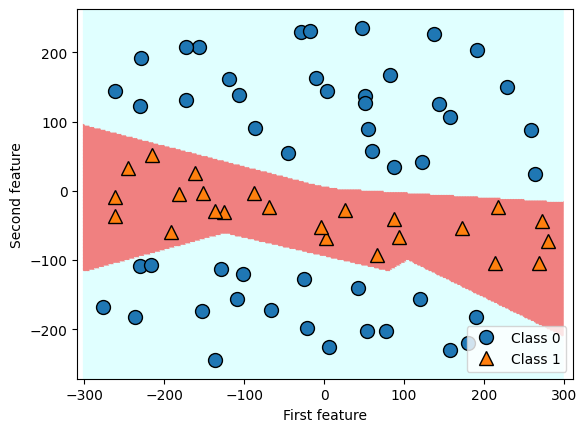

In [17]:
plot_scatter(data0)
plot_bounds(classifier)

In [18]:
print(classifier.accuracy(X_train, y_train))
print(classifier.accuracy(X_test, y_test))

1.0
1.0


In [19]:
print(classifier.confusion_matrix(X_test, y_test))

[[13.  0.]
 [ 0.  6.]]


### Example dataset testing part 1

In [ ]:
data1 = pd.read_csv('drive/MyDrive/Colab/dataset1.csv', delimiter=',').values
X_train, X_test, y_train, y_test = train_test_split(data1[:,0:2], data1[:,2])
classifier = Classifier((2, 5, 5, 5, 2))
classifier.fit(X_train, y_train, epochs=1000)

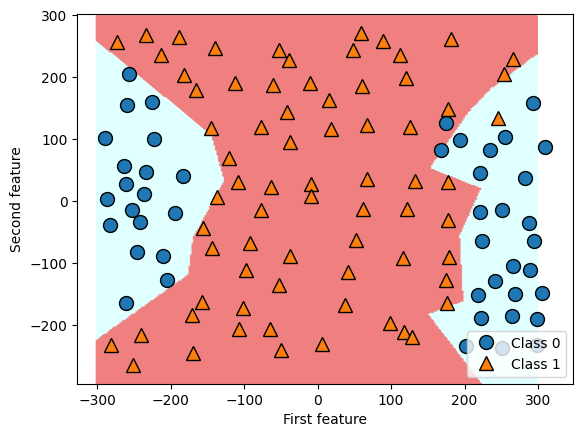

In [21]:
plot_scatter(data1)
plot_bounds(classifier)

In [22]:
print(classifier.accuracy(X_train, y_train))
print(classifier.accuracy(X_test, y_test))

0.9655172413793104
1.0


In [23]:
print(classifier.confusion_matrix(X_test, y_test))

[[14.  0.]
 [ 0. 15.]]


### Example dataset testing part 2

In [ ]:
data2 = pd.read_csv('drive/MyDrive/Colab/dataset2.csv', delimiter=',').values
X_train, X_test, y_train, y_test = train_test_split(data2[:,0:2], data2[:,2])
classifier = Classifier((2, 5, 5, 5, 2))
classifier.fit(X_train, y_train, epochs=500)

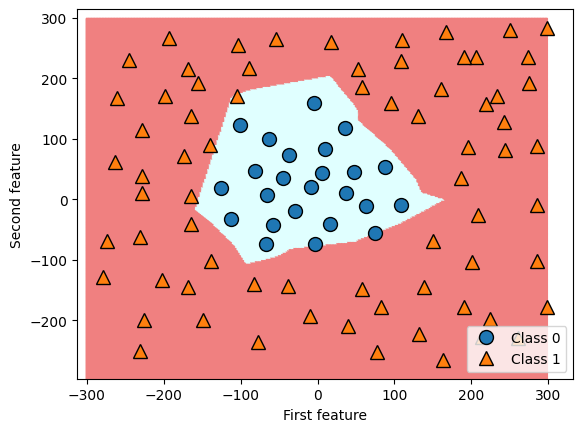

In [25]:
plot_scatter(data2)
plot_bounds(classifier)

In [26]:
print(classifier.accuracy(X_train, y_train))
print(classifier.accuracy(X_test, y_test))

1.0
0.9166666666666666


In [27]:
print(classifier.confusion_matrix(X_test, y_test))

[[ 6.  1.]
 [ 1. 16.]]


### MNIST dataset

In [28]:
def draw_digit(digit):
  current_image = digit
  current_image = current_image.reshape((28, 28))
  plt.gray()
  plt.imshow(current_image, interpolation='nearest')
  plt.show()

In [29]:
train_digit_data = pd.read_csv('drive/MyDrive/Colab/mnist_train.csv', delimiter=',').values
test_digit_data = pd.read_csv('drive/MyDrive/Colab/mnist_test.csv', delimiter=',').values
X_train, y_train = train_digit_data[:573, 1:785], np.array(train_digit_data[:573, 0], dtype=np.uint8)
X_test, y_test = test_digit_data[:, 1:785], np.array(test_digit_data[:, 0], dtype=np.uint8)

In [30]:
classifier = Classifier((784, 10, 10))
classifier.fit(X_train, y_train, epochs=3000)

0: 12.065673355760067
1: 11.77421189433146
2: 11.639866475253235
3: 11.639866475253235
4: 11.013085659365304
5: 10.754917323161571
6: 10.74014390392069
7: 10.338331075068549
8: 9.58637632759787
9: 9.171281975450043
10: 8.335290113963513
11: 8.335290113963513
12: 7.562250828351829
13: 7.562250828351829
14: 6.069864523807142
15: 6.069864523807142
16: 6.069864523807142
17: 5.7092412058915825
18: 4.755653174416406
19: 4.74055556457799
20: 4.386267924731141
21: 3.0046308446672536
22: 3.0046308446672536
23: 3.0046308446672536
24: 3.0046308446672536
25: 3.0046308446672536
26: 3.0046308446672536
27: 3.0046308446672536
28: 3.0046308446672536
29: 3.0046308446672536
30: 2.7591173500192934
31: 2.7591173500192934
32: 2.6701413381676464
33: 2.6701413381676464
34: 2.5305423495609305
35: 2.5305423495609305
36: 2.405405790287629
37: 2.405405790287629
38: 2.405405790287629
39: 2.405405790287629
40: 2.405405790287629
41: 2.405405790287629
42: 2.405405790287629
43: 2.405405790287629
44: 2.3808471219968825

In [31]:
print(classifier.accuracy(X_train, y_train))
print(classifier.accuracy(X_test, y_test))

0.5113438045375218
0.3778162911611785


In [32]:
print(classifier.confusion_matrix(X_test, y_test))

[[44.  0.  1.  0.  0.  3.  1.  0.  0.  0.]
 [ 0. 67.  4.  0.  0.  0.  0.  1.  0.  0.]
 [ 1.  8. 49.  0.  1.  1.  3.  0.  0.  0.]
 [ 1.  3. 46.  0.  1.  6.  1.  0.  0.  0.]
 [ 2.  0. 38.  0. 23.  1.  0.  0.  0.  2.]
 [ 1.  1. 20.  0.  0. 29.  1.  0.  0.  3.]
 [ 1.  1. 39.  0.  0.  2.  6.  0.  0.  1.]
 [ 0.  0. 54.  0.  0.  0.  0.  0.  0.  1.]
 [ 1.  0. 39.  0.  1.  2.  4.  1.  0.  0.]
 [ 0.  0. 59.  0.  1.  0.  1.  0.  0.  0.]]


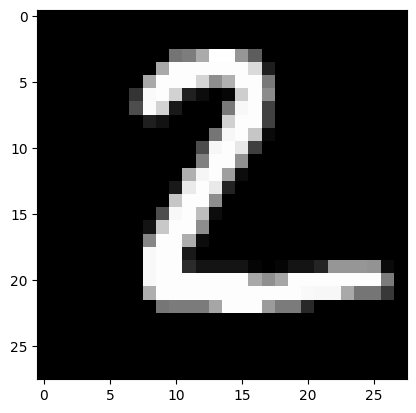

array([1])

In [33]:
two_digit = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,116,125,171,255,255,150,93,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,169,253,253,253,253,253,253,218,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,169,253,253,253,213,142,176,253,253,122,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,52,250,253,210,32,12,0,6,206,253,140,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,251,210,25,0,0,0,122,248,253,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,18,0,0,0,0,209,253,253,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,117,247,253,198,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,76,247,253,231,63,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,128,253,253,144,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,176,246,253,159,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,234,253,233,35,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,198,253,253,141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,78,248,253,189,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,200,253,253,141,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,134,253,253,173,12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,248,253,253,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,248,253,253,43,20,20,20,20,5,0,5,20,20,37,150,150,150,147,10,0,0,0,0,0,0,0,0,0,248,253,253,253,253,253,253,253,168,143,166,253,253,253,253,253,253,253,123,0,0,0,0,0,0,0,0,0,174,253,253,253,253,253,253,253,253,253,253,253,249,247,247,169,117,117,57,0,0,0,0,0,0,0,0,0,0,118,123,123,123,166,253,253,253,155,123,123,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
draw_digit(two_digit)
classifier.predict(two_digit)

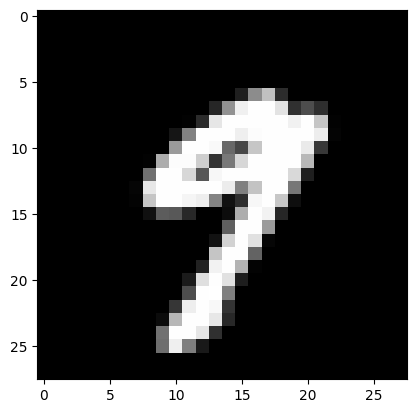

array([2])

In [34]:
nine_digit = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,31,140,193,44,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,38,146,240,254,254,228,48,77,46,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,43,230,254,254,254,254,254,241,254,197,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,130,254,254,254,239,252,254,254,254,254,237,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,154,254,254,249,104,71,198,254,254,254,234,57,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,173,252,252,206,51,120,215,254,254,254,254,184,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,112,254,254,215,87,247,254,254,254,254,254,217,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,231,254,254,254,254,254,236,128,196,254,254,119,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,197,254,254,245,238,131,17,46,247,254,199,14,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16,92,88,40,0,0,12,173,254,242,38,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,95,254,254,155,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,210,254,225,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,197,254,254,99,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,242,254,179,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,27,223,254,225,30,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,77,254,255,127,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,54,238,254,248,53,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,183,254,254,231,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,113,254,254,230,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,110,239,126,25,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
draw_digit(nine_digit)
classifier.predict(nine_digit)

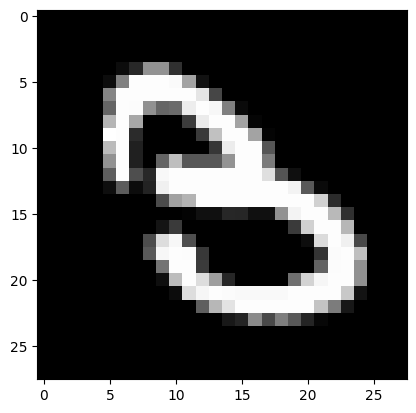

array([2])

In [35]:
three_digit = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,41,146,146,48,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,12,129,253,253,253,250,163,18,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,133,253,253,253,253,253,253,229,70,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,101,253,252,145,102,107,237,253,247,128,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,181,253,167,0,0,0,61,235,253,253,163,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,253,43,0,0,0,0,58,193,253,253,164,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,187,253,32,0,0,0,0,0,55,236,253,253,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,146,253,32,0,100,190,87,87,87,147,253,253,123,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,94,253,78,40,248,253,253,253,253,253,253,253,223,84,15,0,0,0,0,0,0,0,0,0,0,0,0,0,14,92,12,35,240,253,253,253,253,253,253,253,253,253,244,89,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,75,161,179,253,253,253,253,253,253,253,253,253,209,43,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,16,16,39,38,16,16,145,243,253,253,185,48,0,0,0,0,0,0,0,0,0,0,0,0,0,20,58,0,0,0,0,0,0,0,0,58,209,253,253,183,0,0,0,0,0,0,0,0,0,0,0,0,77,221,247,79,0,0,0,0,0,0,0,0,13,219,253,240,72,0,0,0,0,0,0,0,0,0,0,0,90,247,253,252,57,0,0,0,0,0,0,0,0,53,251,253,191,0,0,0,0,0,0,0,0,0,0,0,0,116,253,253,59,0,0,0,0,0,0,0,0,99,252,253,145,0,0,0,0,0,0,0,0,0,0,0,0,14,188,253,221,158,38,0,0,0,0,111,211,246,253,253,145,0,0,0,0,0,0,0,0,0,0,0,0,0,12,221,246,253,251,249,249,249,249,253,253,253,253,200,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,95,183,228,253,253,253,253,253,253,195,124,23,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24,37,138,74,126,88,37,7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
draw_digit(three_digit)
classifier.predict(three_digit)

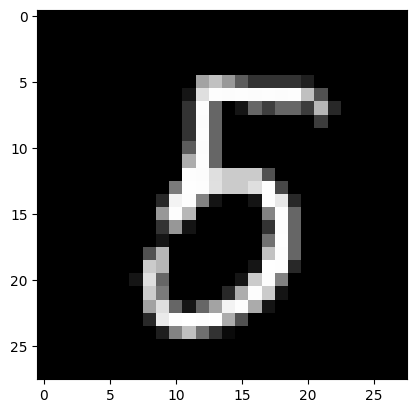

array([5])

In [36]:
five_digit = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,163,193,152,92,51,51,51,51,31,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,223,253,252,253,252,253,252,253,192,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,253,102,0,21,102,62,102,102,61,183,40,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,252,102,0,0,0,0,0,0,0,61,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,253,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,252,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173,253,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,253,252,223,203,203,203,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,123,254,253,224,203,203,223,254,71,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,243,253,130,20,0,0,20,253,232,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,152,253,183,0,0,0,0,0,132,253,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,51,151,20,0,0,0,0,0,51,252,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,0,0,0,0,0,0,0,113,253,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,82,183,0,0,0,0,0,0,0,193,252,102,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,203,183,0,0,0,0,0,0,21,254,253,41,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,21,223,102,0,0,0,0,0,21,203,253,130,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,204,123,0,0,0,0,41,173,253,203,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,162,223,102,21,102,163,243,253,171,20,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,41,234,253,255,253,255,172,82,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,30,131,192,111,50,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])
draw_digit(five_digit)
classifier.predict(five_digit)